In [1]:
%matplotlib inline

import pandas as pd
import itertools

from utils import get_mongo_db

Let's first get the MongoDB instance

In [2]:
db = get_mongo_db()

Connecting to MongoDB at localhost:27017...


Let's now compute the number of repositories per language (keeping in mind that the `repositories` collection contains both repositories owned by our Swiss users, but also any repository that they starred. It's thus a pretty big collection).

In [3]:
db.repositories.count()

200084

Let's first do the aggregation manually in Python:

In [4]:
repos = db.repositories.find({ 'language': { '$ne': None } }, { 'language': True })
repos.count()

184059

In [5]:
repos[0]

{'_id': 24002363, 'language': 'JavaScript'}

In [6]:
counts = {}
for repo in repos:
    if repo['language'] not in counts:
        counts[repo['language']] = 0
    counts[repo['language']] += 1

In [7]:
data = [{ 'language': lang, 'count': counts[lang] } for lang in counts]
df = pd.DataFrame(data).set_index('language')
df.sort_values(by='count', ascending=False)[0:10]

,count
language,
JavaScript,39360
Python,21870
Java,14744
PHP,13973
Ruby,13830
C++,8832
C,8617
Shell,6544
Objective-C,6125


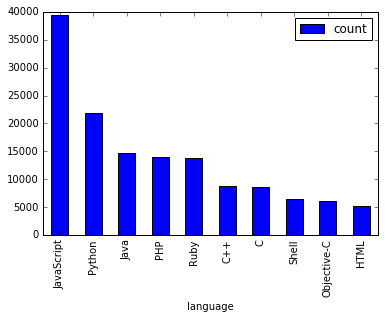

In [8]:
df.sort_values(by='count', ascending=False)[0:10].plot(kind='bar')

Let's now use a potentially more efficient method, using MongoDB's aggregation framework:

In [9]:
from bson.son import SON

In [10]:
pipeline = [
    {
        '$match': {
            'language': { '$ne': None }
        }
    },
    {
        '$group': {
            '_id': '$language',
            'count': { '$sum': 1 }
        }
    },
    {
        '$sort': SON([('count', -1), ('_id', -1)])
    }
]


data = list(db.repositories.aggregate(pipeline))

In [11]:
df = pd.DataFrame(data).rename(columns={ '_id': 'language' }).set_index('language')
df.sort_values(by='count', ascending=False)[0:10]

,count
language,
JavaScript,39360
Python,21870
Java,14744
PHP,13973
Ruby,13830
C++,8832
C,8617
Shell,6544
Objective-C,6125


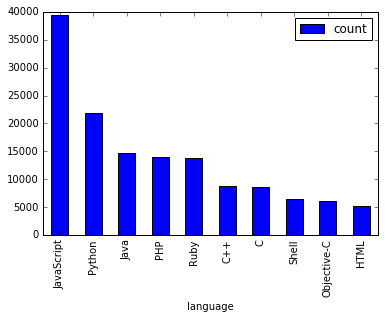

In [12]:
df.sort_values(by='count', ascending=False)[0:10].plot(kind='bar')

Alright, let's now try to retrieve all the Swiss users and their repositories:

In [13]:
res = db.users.find({ 'in_ch': True, 'repositories': { '$ne': None } })

users = []

for user in res:
    repos = db.repositories.find(
        { '_id': { '$in': user['repositories'] } }
    )
    
    users.append({
        '_id': user['_id'],
        'login': user['login'],
        'name': user['name'],
        'location': user['location'],
        'repositories_docs': list(repos)
    })

In [45]:
len(users)

3077

In [17]:
users[1]['repositories_docs'][0]

{'_id': 546522,
 'clone_url': 'https://github.com/Seldaek/phergie.git',
 'created_at': datetime.datetime(2010, 3, 4, 12, 46, 24),
 'fork': True,
 'forks_count': 1,
 'full_name': 'Seldaek/phergie',
 'has_downloads': False,
 'has_issues': False,
 'has_pages': False,
 'homepage': 'http://phergie.org',
 'language': 'PHP',
 'name': 'phergie',
 'open_issues': 0,
 'open_issues_count': 0,
 'owner_id': 183678,
 'private': False,
 'size': 324,
 'stargazers_count': 3,
 'watchers_count': 3}

Let's now try using MongoDB's aggregation framework:

In [18]:
pipeline = [
    {
        '$match': { 'in_ch': True, 'repositories': { '$ne': None } }
    },
    {
        '$lookup': {
            'from': 'repositories',
            'localField': '_id',
            'foreignField': 'owner_id',
            'as': 'repositories_docs'
        }
    },
    {
        '$project': {
            'login': True,
            'name': True,
            'location': True,
            'repositories_docs': True
        }
    }
]

data = list(db.users.aggregate(pipeline))

In [19]:
len(data)

5976

In [21]:
data[1]['repositories_docs'][0]

{'_id': 6427443,
 'clone_url': 'https://github.com/Seldaek/ActivDevNoclineBundle.git',
 'created_at': datetime.datetime(2012, 10, 28, 12, 50, 43),
 'fork': True,
 'forks_count': 0,
 'full_name': 'Seldaek/ActivDevNoclineBundle',
 'has_downloads': True,
 'has_issues': False,
 'has_pages': False,
 'homepage': '',
 'language': 'PHP',
 'name': 'ActivDevNoclineBundle',
 'open_issues': 0,
 'open_issues_count': 0,
 'owner_id': 183678,
 'private': False,
 'size': 182,
 'stargazers_count': 4,
 'watchers_count': 4}

We can now try to get the list of all the repositories owned by a Swiss user:

In [22]:
ch_users = db.users.find({ 'in_ch': True }, { '_id': True })
ch_users_ids = [u['_id'] for u in ch_users]

In [23]:
pipeline = [
    {
        '$match': { 'owner_id': { '$in': ch_users_ids } }
    }
]

data = list(db.repositories.aggregate(pipeline))

In [24]:
len(data)

98862

In [25]:
data[1]

{'_id': 77803695,
 'clone_url': 'https://github.com/octave/email_address.git',
 'created_at': datetime.datetime(2017, 1, 2, 0, 55, 36),
 'fork': True,
 'forks_count': 0,
 'full_name': 'octave/email_address',
 'has_downloads': True,
 'has_issues': False,
 'has_pages': False,
 'homepage': '',
 'language': 'Ruby',
 'name': 'email_address',
 'open_issues': 0,
 'open_issues_count': 0,
 'owner_id': 343,
 'private': False,
 'size': 140,
 'stargazers_count': 0,
 'watchers_count': 0}

Alternatively:

In [26]:
pipeline = [
    {
        '$match': { 'in_ch': True, 'repositories': { '$ne': None } }
    },
    {
        '$lookup': {
            'from': 'repositories',
            'localField': '_id',
            'foreignField': 'owner_id',
            'as': 'repositories_docs'
        }
    },
    {
        '$unwind': '$repositories_docs'
    },
    {
        '$replaceRoot': { 'newRoot': '$repositories_docs' }
    }
]

data = list(db.users.aggregate(pipeline))
len(data)

98862

In [27]:
data[0]

{'_id': 24002363,
 'clone_url': 'https://github.com/vhf/absorb.git',
 'created_at': datetime.datetime(2014, 9, 13, 18, 38, 2),
 'fork': False,
 'forks_count': 1,
 'full_name': 'vhf/absorb',
 'has_downloads': True,
 'has_issues': True,
 'has_pages': True,
 'homepage': None,
 'language': 'JavaScript',
 'name': 'absorb',
 'open_issues': 0,
 'open_issues_count': 0,
 'owner_id': 2022803,
 'private': False,
 'size': 5,
 'stargazers_count': 1,
 'watchers_count': 1}

For the record, the above aggregation query is available as a read-only view, called `ch_repositories_view`:

In [28]:
data = list(db.ch_repositories_view.find())
len(data)

98862

In [29]:
data[0]

{'_id': 24002363,
 'clone_url': 'https://github.com/vhf/absorb.git',
 'created_at': datetime.datetime(2014, 9, 13, 18, 38, 2),
 'fork': False,
 'forks_count': 1,
 'full_name': 'vhf/absorb',
 'has_downloads': True,
 'has_issues': True,
 'has_pages': True,
 'homepage': None,
 'language': 'JavaScript',
 'name': 'absorb',
 'open_issues': 0,
 'open_issues_count': 0,
 'owner_id': 2022803,
 'private': False,
 'size': 5,
 'stargazers_count': 1,
 'watchers_count': 1}

In [30]:
data = list(db.users.find(
    {'in_ch': True, 'location': { '$ne': None }, 'geocode': None },
    { 'location': True }
))

In [31]:
len(data)

35

In [32]:
data[0]

{'_id': 756703, 'location': 'From GER, now in CH'}

In [33]:
locations = set([loc['location'] for loc in data])
len(locations)

35

In [34]:
df = pd.DataFrame([{'location': loc} for loc in locations]).sort_values(by='location').reset_index()

In [35]:
df

,index,location
0,3,/var/log/
1,21,5/23 VALMIKI ST EAST TAMBARAM CH-59
2,14,Bookspage
3,20,"Bottighofen, CH & Munich, DE & Poznan, PL"
4,15,CH GD SZ
5,11,"D4 Business Center, Root Längenbold, CH-6037"
6,28,"Delaware, USA | Melbourne, AU | Zug, CH | Shan..."
7,13,Espace Gruyère SA Rue de Vevey 136-144 Case po...
8,6,"From GER, now in CH"
9,10,"HANGZHOU ZHEJIANG CH / CHICAGO, US"


In [36]:
data = db.users.find({ 'geocode.country': { '$ne': None } }, { 'geocode.country': True })

In [37]:
data.count()

5935

In [38]:
countries = set([ x['geocode']['country'] for x in data ])

In [39]:
countries

{'124',
 'AU',
 'AZ',
 'Australia',
 'BE',
 'BR',
 'België - Belgique - Belgien',
 'Bolivia',
 'CA',
 'CH',
 'CN',
 'CO',
 'CZ',
 'Canada',
 'DE',
 'DK',
 'Danmark',
 'Deutschland',
 'EE',
 'ES',
 'El Salvador',
 'España',
 'FI',
 'FR',
 'France',
 'GB',
 'GR',
 'HK',
 'HU',
 'IE',
 'IT',
 'India',
 'Italia',
 'JP',
 'LT',
 'Mauritanie موريتانيا',
 'México',
 'NL',
 'NZ',
 'Nederland',
 'Norge',
 'PT',
 'Philippines',
 'Polska',
 'România',
 'SA',
 'SE',
 'SZ',
 'Schweiz, Suisse, Svizzera, Svizra',
 'Singapore',
 'Swaziland',
 'TR',
 'Türkiye',
 'UA',
 'UK',
 'US',
 'United States of America',
 'Viti',
 'Việt Nam',
 'ZA',
 'Österreich',
 'Česko',
 'Ελλάδα',
 'РФ',
 'Србија',
 'Тоҷикистон',
 'Україна',
 'السعودية',
 'ประเทศไทย',
 '中国',
 '日本'}